# Experiment1: Entropy Minimization

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt

### MNIST Data

In [6]:
# Load the labeled data from the .npz file
data = np.load('./Saved_Data/labeled_dataset_MNIST.npz')
labeled_images = data['images']
labled_labels = data['labels']

# Convert data to PyTorch tensors
labeled_images = torch.tensor(labeled_images, dtype=torch.float32)
labled_labels = torch.tensor(labled_labels, dtype=torch.long)

# Create a TensorDataset and DataLoader
labeled_dataset = TensorDataset(labeled_images, labled_labels)
labeled_dataloaderMnist = DataLoader(labeled_dataset, batch_size=10, shuffle=True)



# Load the un-labeled data from the .npz file
data = np.load('./Saved_Data/unlabeled_dataset_MNIST.npz')
unlabeled_images = data['images']
unlabeled_labels = data['labels']

# Convert data to PyTorch tensors
unlabeled_images = torch.tensor(unlabeled_images, dtype=torch.float32)
unlabeled_labels = torch.tensor(unlabeled_labels, dtype=torch.long)

# Create a TensorDataset and DataLoader
unlabeled_dataset = TensorDataset(unlabeled_images, unlabeled_labels)
unlabeled_dataloaderMnist = DataLoader(unlabeled_dataset, batch_size=50, shuffle=True)

In [22]:
class MnistNet(nn.Module):

    def __init__(self):

        super(MnistNet,self).__init__()
        self.flatten = nn.Flatten()
        self.fullyConnectedLayer = nn.Sequential(
            
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200,10)
        )

    def forward(self, input):
        
        input = self.flatten(input)
        output = self.fullyConnectedLayer(input)
        activatedOutput = F.log_softmax(output, dim = 1)

        return activatedOutput

In [8]:
#Create entropy loss for the unlabeled data 

def entropy_loss(logits):
    log_p = F.log_softmax(logits, dim=1)
    p = torch.exp(log_p)  # This is equivalent to softmax
    loss = -torch.sum(p * log_p, dim=1).mean()
    return loss

In [17]:
def calculate_accuracy(loader, model, dataMNIST = True):
    
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [43]:


# Training Function
def trainAndPlot(model, labeled_loader, unlabeled_loader, epochs=5, lr=0.001, alpha=0.1, readingAtEpoch = 10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Lists to store metrics
    supervised_losses = []
    unsupervised_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        for (labeled_data, labels), (unlabeled_data, _) in zip(labeled_loader, unlabeled_loader):
            # Forward pass for labeled data
            optimizer.zero_grad()
            
            outputs = model(labeled_data)
            loss = criterion(outputs, labels)

            # Forward pass for unlabeled data
            unlabeled_outputs = model(unlabeled_data)
            entropy_loss_unlabeled = entropy_loss(unlabeled_outputs)
            total_loss = loss + alpha * entropy_loss_unlabeled

            # Backward and optimize
            total_loss.backward()
            optimizer.step()

        if epoch%readingAtEpoch==0:

            supervised_loss_value = loss.item()
            unsupervised_loss_value = entropy_loss_unlabeled.item()
            train_accuracy_value = calculate_accuracy(labeled_loader, model)
            test_accuracy_value = calculate_accuracy(unlabeled_loader, model)

            supervised_losses.append(supervised_loss_value)
            unsupervised_losses.append(unsupervised_loss_value)
            train_accuracies.append(train_accuracy_value)
            test_accuracies.append(test_accuracy_value)

            print(f"Epoch {epoch}: Supervised Loss: {supervised_loss_value}, "
                f"Unsupervised Loss: {unsupervised_loss_value}, "
                f"Training Accuracy: {train_accuracy_value}, "
                f"Testing Accuracy: {test_accuracy_value}")
            

    epochs = range(0, epochs, readingAtEpoch)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, supervised_losses, label='Supervised Training Loss')
    plt.plot(epochs, unsupervised_losses, label='Entropy Loss')
    plt.title('Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Labeled Accuracy')
    plt.plot(epochs, test_accuracies, label='Unlabeled Accuracy')
    plt.title('Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Epoch 0: Supervised Loss: 2.3084473609924316, Unsupervised Loss: 2.3020260334014893, Training Accuracy: 12.0, Testing Accuracy: 12.05050505050505
Epoch 10: Supervised Loss: 2.199350118637085, Unsupervised Loss: 2.3000268936157227, Training Accuracy: 70.0, Testing Accuracy: 49.343434343434346
Epoch 20: Supervised Loss: 1.824121117591858, Unsupervised Loss: 2.248914957046509, Training Accuracy: 78.0, Testing Accuracy: 59.23232323232323
Epoch 30: Supervised Loss: 1.1375268697738647, Unsupervised Loss: 2.0892367362976074, Training Accuracy: 85.0, Testing Accuracy: 63.676767676767675
Epoch 40: Supervised Loss: 1.1301674842834473, Unsupervised Loss: 1.6888819932937622, Training Accuracy: 87.0, Testing Accuracy: 66.5959595959596
Epoch 50: Supervised Loss: 0.8232958912849426, Unsupervised Loss: 1.4783997535705566, Training Accuracy: 89.0, Testing Accuracy: 68.36363636363636
Epoch 60: Supervised Loss: 0.6205548048019409, Unsupervised Loss: 1.4447572231292725, Training Accuracy: 93.0, Testing Ac

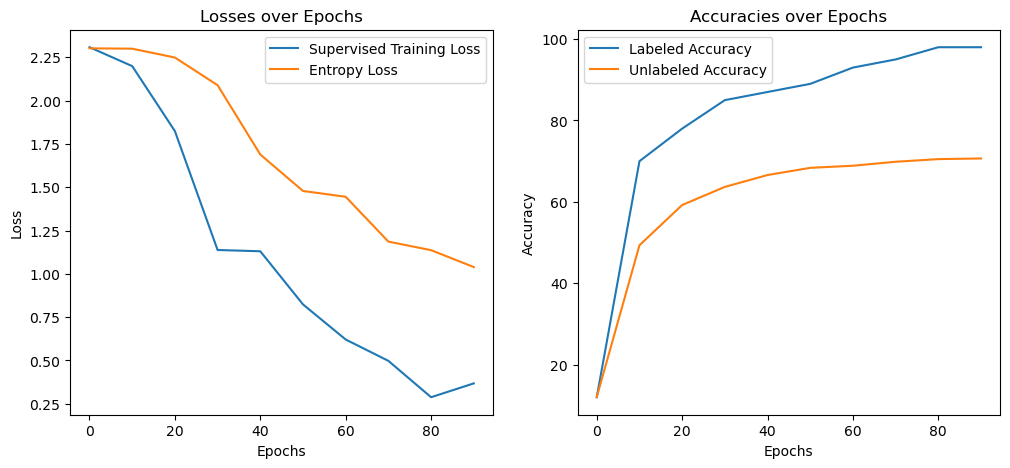

In [55]:

EntropyModel_MNIST = MnistNet()

trainAndPlot(model=EntropyModel_MNIST,
      labeled_loader=labeled_dataloaderMnist,
      unlabeled_loader=unlabeled_dataloaderMnist,
      epochs=100,
      lr = 0.002,
      alpha=0.1)

### Two Moons Dataset

In [56]:
selected_samples = np.load('./Saved_Data/labeled_dataset_TwoMoons.npy')

remaining_samples = np.load('./Saved_Data/unlabeled_dataset_TwoMoons.npy')

# Converting the selected samples and remaining samples into PyTorch tensors
selected_samples_tensor = torch.tensor(selected_samples, dtype=torch.float32)
remaining_samples_tensor = torch.tensor(remaining_samples, dtype=torch.float32)

# Extracting features and labels for both datasets
features_selected = selected_samples_tensor[:, :2]
labels_selected = selected_samples_tensor[:, 2].long()  # converting labels to long for classification

features_remaining = remaining_samples_tensor[:, :2]
labels_remaining = remaining_samples_tensor[:, 2].long()

# Creating TensorDatasets
selected_dataset = TensorDataset(features_selected, labels_selected)
remaining_dataset = TensorDataset(features_remaining, labels_remaining)

# Creating DataLoaders
labeled_dataloaderTM = DataLoader(selected_dataset, batch_size=1)  # small batch size for the small dataset
unlabeled_dataloaderTM = DataLoader(remaining_dataset, batch_size=5)  # larger batch size for the larger dataset

In [57]:
class TwoMoonsNet(nn.Module):

    def __init__(self):

        super(TwoMoonsNet,self).__init__()

        self.fullyConnectedLayer = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10,2)
        )

    def forward(self, input):

        output = self.fullyConnectedLayer(input)
        activatedOutput = F.log_softmax(output, dim = 1)

        return activatedOutput

Epoch 0: Supervised Loss: 0.7034845948219299, Unsupervised Loss: 0.6848257780075073, Training Accuracy: 33.333333333333336, Testing Accuracy: 17.010309278350515
Epoch 2: Supervised Loss: 0.7104131579399109, Unsupervised Loss: 0.6860765218734741, Training Accuracy: 33.333333333333336, Testing Accuracy: 17.52577319587629
Epoch 4: Supervised Loss: 0.7130547761917114, Unsupervised Loss: 0.6865302324295044, Training Accuracy: 33.333333333333336, Testing Accuracy: 18.556701030927837
Epoch 6: Supervised Loss: 0.7110098600387573, Unsupervised Loss: 0.6870630979537964, Training Accuracy: 33.333333333333336, Testing Accuracy: 22.164948453608247
Epoch 8: Supervised Loss: 0.7067016959190369, Unsupervised Loss: 0.687296450138092, Training Accuracy: 50.0, Testing Accuracy: 29.896907216494846
Epoch 10: Supervised Loss: 0.7006087303161621, Unsupervised Loss: 0.687267005443573, Training Accuracy: 66.66666666666667, Testing Accuracy: 47.93814432989691
Epoch 12: Supervised Loss: 0.6954781413078308, Unsup

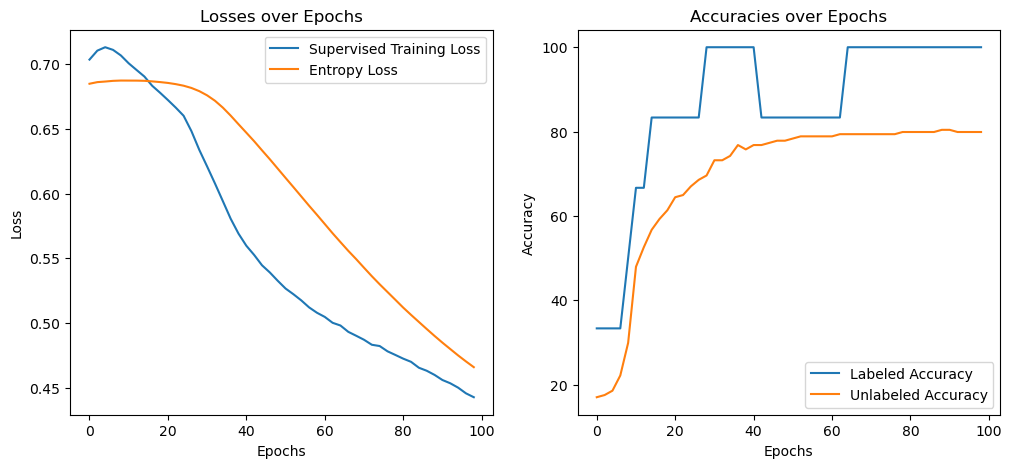

In [60]:
EntropyModel_TwoMoons = TwoMoonsNet()

trainAndPlot(model=EntropyModel_TwoMoons,
      labeled_loader=labeled_dataloaderTM,
      unlabeled_loader=unlabeled_dataloaderTM,
      epochs=100,
      lr = 0.002,
      alpha=0.01,
      readingAtEpoch=2)

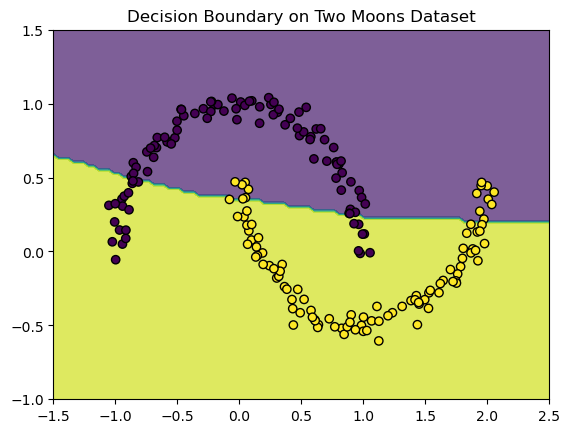

In [61]:
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

EntropyModel_TwoMoons.eval()
with torch.no_grad():
    predictions = EntropyModel_TwoMoons(grid_tensor)
    classes = torch.argmax(predictions, dim=1).numpy().reshape(xx.shape)

plt.contourf(xx, yy, classes, alpha=0.7)
plt.scatter(selected_samples[:, 0], selected_samples[:, 1], c=selected_samples[:, 2], edgecolor='k')
plt.scatter(remaining_samples[:, 0], remaining_samples[:, 1], c=remaining_samples[:, 2], edgecolor='k')
plt.title("Decision Boundary on Two Moons Dataset")
plt.show()